In [36]:
%run talktools.py

###  Sao Paulo School of Advanced Science on Learning from Data, July 31 - Aug 2, 2019
### Big Data Sets in Astronomy, Zeljko Ivezic, University of Washington
https://github.com/dirac-institute/uw-astr598-w18/tree/master/SPSAS2019/SPSAS2019day3-2.ipynb

# Day 3: Dimensionality reduction, Regression and Time Series Analysis in Astronomy




# Regression and Time Series Analysis 


In [37]:
%matplotlib inline
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import pymc as pymc
import seaborn as sns
from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
# random seed 
np.random.seed(42)

## To warm up let's fit a straight line to data, using varying assumptions about measurement errors

In [38]:
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse principal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))
        
# Find best-fit parameters
def get_best_fit(x, y, sigma_x, sigma_y, rho_xy):
    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = sigma_x ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

    # note: TLS_logL was imported from astroML.linear_model 
    min_func = lambda beta: -TLS_logL(beta, X, dX)
    # this is optimization, not MCMC
    return optimize.fmin(min_func, x0=[-1, 1])


# plot results 
def plot_best_fit(x, y, sigma_x, sigma_y, rho_xy, beta_fit, mLSQ, bLSQ):
    fig = plt.figure(figsize=(8, 5))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25, bottom=0.15, top=0.9)
    ax = fig.add_subplot(121)
    ax.scatter(x, y, c='k', s=9)
    plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)
    
    # plot the best-fit line
    m_fit, b_fit = get_m_b(beta_fit)
    x_fit = np.linspace(0, 300, 10)
    ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')
    ax.plot(x_fit, mLSQ * x_fit + bLSQ, '--', c='red')

    ax.set_xlim(40, 250)
    ax.set_ylim(100, 600)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    # plot the likelihood contour in m, b
    ax = fig.add_subplot(122)
    m = np.linspace(1.7, 2.8, 100)
    b = np.linspace(-60, 110, 100)
    logL = np.zeros((len(m), len(b)))

    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = sigma_x ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y
    for i in range(len(m)):
        for j in range(len(b)):
            logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

    ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997), colors='k')
    ax.plot([-1000, 1000], [bLSQ, bLSQ], ':k', lw=1, c='red')
    ax.plot([mLSQ, mLSQ], [-1000, 1000], ':k', lw=1, c='red')

    ax.set_xlabel('slope')
    ax.set_ylabel('intercept')
    ax.set_xlim(1.7, 2.8)
    ax.set_ylim(-60, 110)

    plt.show()

In [39]:
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers (the first 5 points are outliers, see the lecture)
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

In [40]:
# for comparison, let's get the standard LSQ solution
mux = np.mean(x)
muy = np.mean(y)
mLSQ = np.sum(x*y-mux*muy)/np.sum((x-mux)**2)
bLSQ = muy - mLSQ*mux
print 'mLSQ=', mLSQ
print 'bLSQ=', bLSQ 

mLSQ= 2.191027996426704
bLSQ= 32.00396939102313


Optimization terminated successfully.
         Current function value: 56.688229
         Iterations: 85
         Function evaluations: 160
m= 2.299303276704902
b= 24.151505990843706


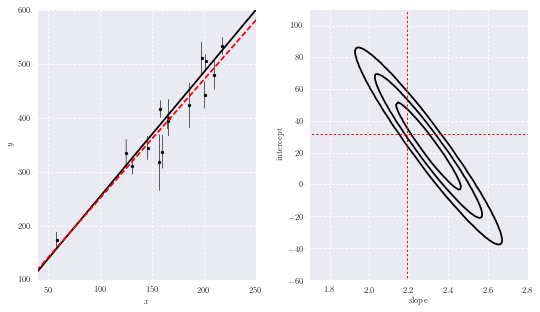

In [41]:
## let's do only errors in y - this is standard LSQ 
# Find best-fit parameters
err_x = 0*sigma_x
err_y = sigma_y
rho = 0*rho_xy
best_fit1 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit1, b_fit1 = get_m_b(best_fit1)
print 'm=', m_fit1
print 'b=', b_fit1
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit1, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 72.220549
         Iterations: 171
         Function evaluations: 318
m= 2.596107117541477
b= -43.9768263126515


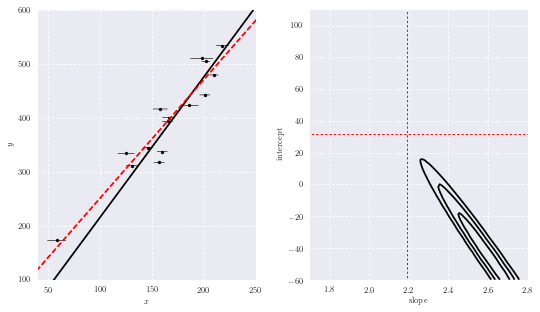

In [42]:
## now only errors in x; note that we could switch the axes and use standard LSQ
# Find best-fit parameters
err_x = sigma_x
err_y = 0*sigma_y
rho = rho_xy
best_fit2 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit2, b_fit2 = get_m_b(best_fit2)
print 'm=', m_fit2
print 'b=', b_fit2
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit2, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 56.630031
         Iterations: 71
         Function evaluations: 136
m= 2.3849344880407286
b= 6.042234007073399


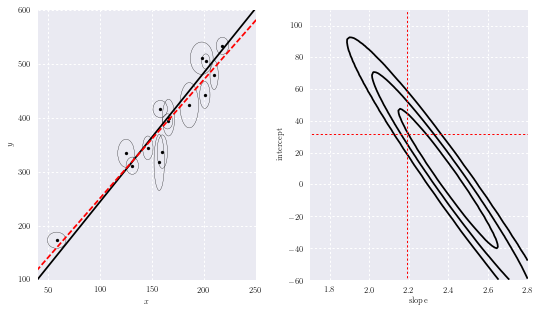

In [43]:
## errors in x and y, but without covariance
# Find best-fit parameters
err_x = sigma_x
err_y = sigma_y
rho = 0*rho_xy
best_fit3 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit3, b_fit3 = get_m_b(best_fit3)
print 'm=', m_fit3
print 'b=', b_fit3
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit3, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164
m= 2.248785375229947
b= 27.930434942133815


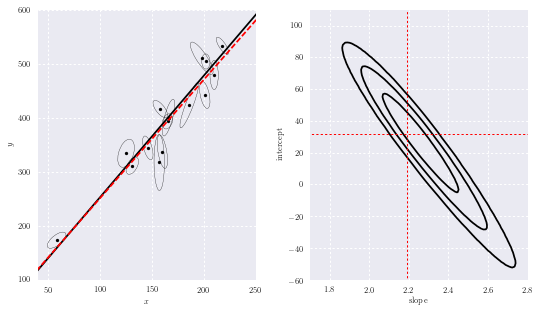

In [44]:
## errors in x and y with covariance
# Find best-fit parameters
err_x = sigma_x
err_y = sigma_y
rho = rho_xy
best_fit4 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit4, b_fit4 = get_m_b(best_fit4)
print 'm=', m_fit4
print 'b=', b_fit4
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit4, mLSQ, bLSQ)

In [45]:
# compare all 4 versions and LSQ
print 'm=', m_fit1, m_fit2, m_fit3, m_fit4, mLSQ

m= 2.299303276704902 2.596107117541477 2.3849344880407286 2.248785375229947 2.191027996426704


## MCMC-based more general method

### Let's now solve the same straight line fitting problem using MCMC 

In [46]:
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers (the first 5 points are outliers, see the lecture)
x_obs = data['x']
y_obs = data['y']
x_error = data['sigma_x']
y_error = data['sigma_y']

In [47]:
def doMCMC(xObs, yObs, xErr, yErr, doXerror = False, nChain = 10000, nBurn = 2000): 
    def model(xObs, yObs, xErr, yErr, doXerror): 
        b = pymc.Uniform('b', -100, 100, value= 0.0)
        m = pymc.Uniform('m', -1000, 1000, value= 1.0)

        if (doXerror):
            xLatent = pymc.Normal('x', mu=xObs, tau=(xErr)**-2)  
        else:
            xLatent = xObs 
        
        @pymc.deterministic()
        def straightLine(x=xLatent, b=b, m=m):
            return m*x + b
    
        y = pymc.Normal('y', mu=straightLine, tau=(yErr)**-2, value=yObs, observed=True)
        return locals()

    myModel = pymc.MCMC(model(xObs,yObs, xErr, yErr, doXerror))
    myModel.sample(nChain, nBurn, 1)
    traces = [myModel.trace(s)[:] for s in ['b', 'm']]
    M = pymc.MAP(myModel)
    M.fit()
    fit_vals = (M.b.value, M.m.value)
    return traces, fit_vals

In [48]:
# run MCMC for the straight line fit
traces, fit_vals = doMCMC(x_obs, y_obs, x_error, y_error, True, 200000, 20000)

 [-----------------100%-----------------] 200000 of 200000 complete in 29.1 sec

In [49]:
print "BASIC STATS:"
print 'b:', np.mean(traces[0]), np.median(traces[0]), np.std(traces[0])
print 'm:', np.mean(traces[1]), np.median(traces[1]), np.std(traces[1])
print 'old (fast) results for b and m:', b_fit3, m_fit3 

BASIC STATS:
b: 26.976432249323047 28.689713904862955 27.990927277773903
m: 2.2611537218143836 2.2518831474799814 0.16120853575041713
old (fast) results for b and m: 6.042234007073399 2.3849344880407286


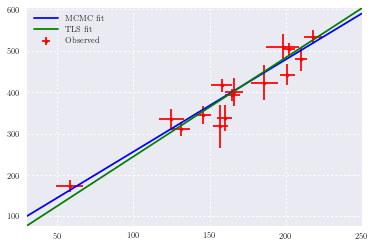

In [50]:
# extract and plot results
x_fit = np.linspace(30,250,220)
yfitMCMC = fit_vals[0] + fit_vals[1] * x_fit
yfitTLS = b_fit3 + m_fit3 * x_fit
plt.errorbar(x_obs,y_obs,xerr=x_error, yerr=y_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x_fit,yfitMCMC,'-', c='blue', label='MCMC fit')
plt.plot(x_fit,yfitTLS,'-', c='green', label='TLS fit')
plt.legend()
plt.show()

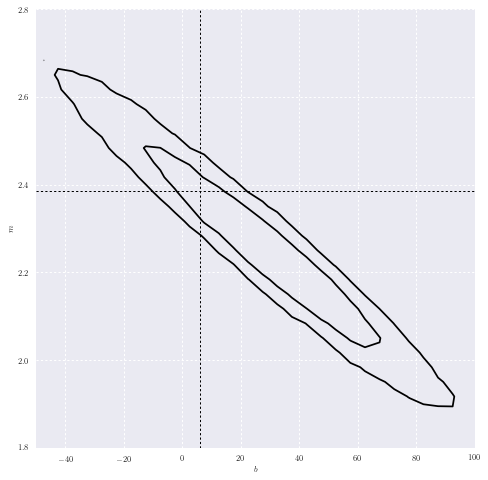

In [51]:
###  look at the posterior pdf p(b,m) from MCMC 
# a helper routine for more informative plots
from astroML.plotting.mcmc import plot_mcmc

labels = ['$b$', '$m$']
limits = [(-50, 100), (1.8, 2.8)]
TLS = [b_fit3, m_fit3]
 
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=TLS, fig=fig,
          bins=30, colors='k')

plt.show()

In [52]:
### now let's redo the above code to be able to do a parabola
### y = a + b*x + c*x^2 
def doMCMCparabola(xObs, yObs, xErr, yErr, doXerror = False, nChain = 10000, nBurn = 2000): 
    def model(xObs, yObs, xErr, yErr, doXerror): 
        a = pymc.Uniform('a', -1000, 1000, value= 1.0)
        b = pymc.Uniform('b', -1000, 1000, value= 0.0)
        c = pymc.Uniform('c', -1000, 1000, value= 0.0)

        if (doXerror):
            xLatent = pymc.Normal('x', mu=xObs, tau=(xErr)**-2)  
        else:
            xLatent = xObs 
        
        @pymc.deterministic()
        def parabola(x=xLatent, a=a, b=b, c=c):
            return a + b*x + c*x*x
    
        y = pymc.Normal('y', mu=parabola, tau=(yErr)**-2, value=yObs, observed=True)
        return locals()

    myModel = pymc.MCMC(model(xObs,yObs, xErr, yErr, doXerror))
    myModel.sample(nChain, nBurn, 1)
    traces = [myModel.trace(s)[:] for s in ['a', 'b', 'c']]
    M = pymc.MAP(myModel)
    M.fit()
    fit_vals = (M.a.value, M.b.value, M.c.value)
    return traces, fit_vals

In [53]:
# run MCMC for the parabola fit
traces, fit_vals = doMCMCparabola(x_obs, y_obs, x_error, y_error, True, 200000, 20000)

 [-----------------100%-----------------] 200000 of 200000 complete in 40.3 sec

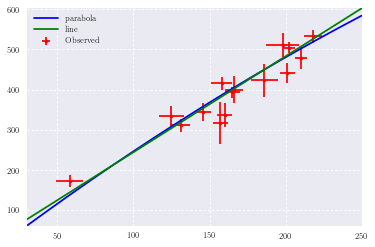

In [54]:
# extract and plot results
x_fit = np.linspace(30,250,220)
yfitParabola = fit_vals[0] + fit_vals[1] * x_fit + fit_vals[2] * x_fit*x_fit
yfitLine = b_fit3 + m_fit3 * x_fit
plt.errorbar(x_obs,y_obs,xerr=x_error, yerr=y_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x_fit,yfitParabola,'-', c='blue', label='parabola')
plt.plot(x_fit,yfitLine,'-', c='green', label='line')
plt.legend()
plt.show()

In [55]:
print "BASIC STATS:"
print 'a:', np.mean(traces[0]), np.median(traces[0]), np.std(traces[0])
print 'b:', np.mean(traces[1]), np.median(traces[1]), np.std(traces[1])
print 'c:', np.mean(traces[2]), np.median(traces[2]), np.std(traces[2])

BASIC STATS:
a: 67.57476122411452 71.4604154668456 57.248924134765076
b: 1.5976760585771337 1.574934255569625 0.8144669799411507
c: 0.0023521071336972225 0.0023361451831462004 0.0027834731536667888


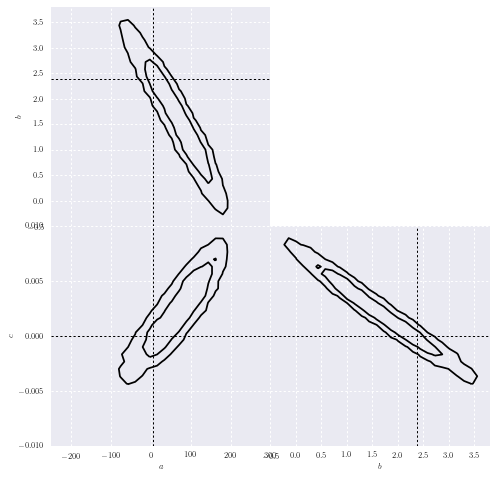

In [56]:
labels = ['$a$', '$b$', '$c$']
limits = [(-250, 300), (-0.5, 3.8), (-0.01, 0.01)]
TLS = [b_fit3, m_fit3, 0.0]
 
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.3, top=0.8, left=0.15, right=0.9,
                    hspace=0.15, wspace=0.15)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=TLS, fig=fig,
          bins=30, colors='k')

plt.show()

## Gaussian regression 

### We don’t have to use polynomials; we can use any set of basis functions

### Gaussian basis functions are often very convenient, e.g. for convolution
 

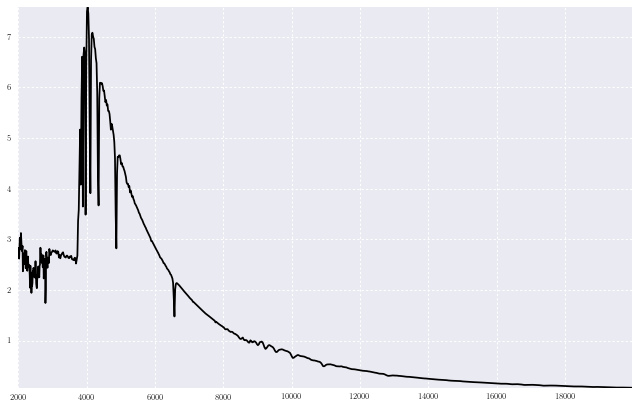

In [57]:
from astroML.datasets import fetch_vega_spectrum
# Fetch the data
x, y = fetch_vega_spectrum()
# truncate the spectrum
mask = (x >= 2000) & (x < 20000)
x = x[mask]
y = y[mask]*1.0e14

# a quick plot 
plt.figure(figsize=(11, 7))
plt.plot(x, y, '-k', label='input spectrum')
plt.show()

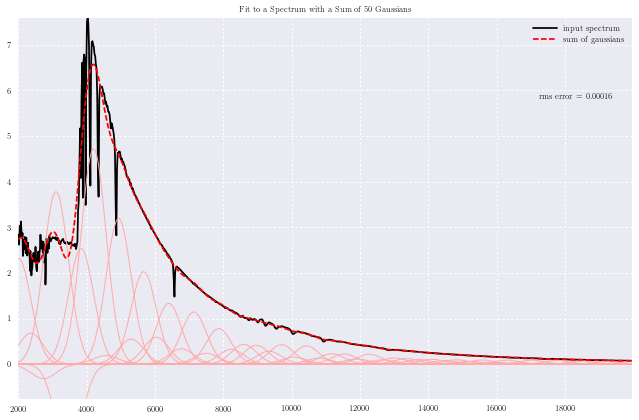

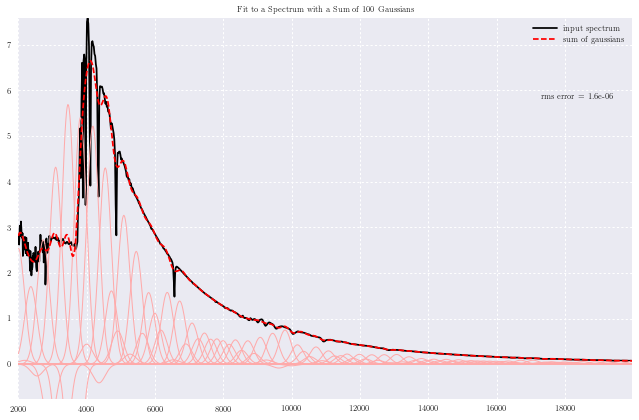

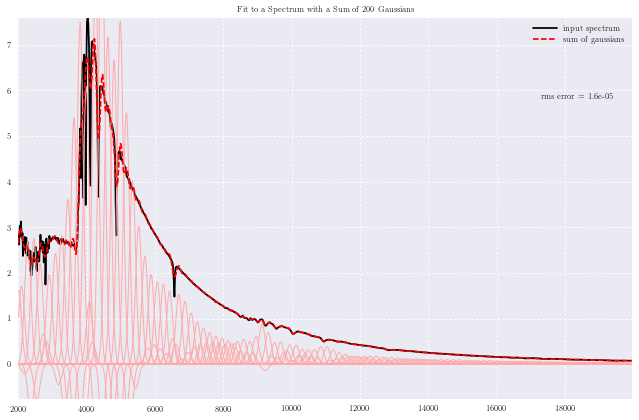

In [58]:
from astroML.sum_of_norms import sum_of_norms, norm
for n_gaussians in (50, 100, 200):
    # compute the best-fit linear combination
    w_best, rms, locs, widths = sum_of_norms(x, y, n_gaussians,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(x[:, None], locs, widths)
    # convolve with a gaussian instrumental resolution 
    widths2 = np.sqrt(widths**2 + 50**2)
    norms2 = w_best * norm(x[:, None], locs, widths2)


    # plot the results
    plt.figure(figsize=(11, 7))
    plt.plot(x, y, '-k', label='input spectrum')
    ylim = plt.ylim()

    plt.plot(x, norms, ls='-', c='#FFAAAA', lw=1)
    plt.plot(x, norms.sum(1), '--r', label='sum of gaussians')

    # plt.plot(x, norms2, ls='-', c='blue', lw=1)
    # plt.plot(x, norms2.sum(1), '-b', label='convolved')

    plt.ylim(-0.1 * ylim[1], ylim[1])
    plt.legend(loc=0)
    plt.text(0.97, 0.8,
             "rms error = %.2g" % rms,
             ha='right', va='top', transform=plt.gca().transAxes)
    plt.title("Fit to a Spectrum with a Sum of %i Gaussians" % n_gaussians)

plt.show()


# Time Series Analysis

Time series analysis is, in many ways, very similar to regression analysis except that we replace $x$ with $t$.  
In regression applications, we generally assume that the $y$ values are independent, whereas for time series $y_{i+1}$ is likely to depend directly on $y_i$.  Furthermore, we make no assumptions about the regularity of the time sampling.

There is a broad range of variability signatures that we want to be aware of. From transient events to periodic variables to stochastic sources.

<img src="figures/flare.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="figures/cepheid.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="figures/eclipsing.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

## Examples of Time Series Analysis

### Topics for today:
- Fourier analysis
- Period search
- Searching for chirps and bursts in a time series

### and had to descope: 
- Stochastic variability



 

## Goals

When dealing with time series data, the first thing that we want to know is if the system that we are studying is even variable (otherwise, there is no point doing time series analysis!).  In the context of frequentist statistics, this is a question of whether our data would have been obtained by chance if the no-variability null hypothesis were correct.

If we find that our source *is* variable, then our time-series analysis has two main goals:
1. Characterize the temporal correlation between different values of $y$ (i.e., characterize the "light curve").  For example by learning the parameters for a model.
2. Predict future values of $y$.

## Fourier Analysis

Fourier Analysis could be the subject for an entire class as opposed to a short part of a single lecture. 

The code below demostrates an application that you are surely familiar with: reconstruction of a complicated signal by summation of simpler trig functions.


![FT](figures/fourier.tiff)

![FT](figures/fourier2.tiff)

![FT](figures/fourier3.tiff)

![FT](figures/fourier4.tiff)




 

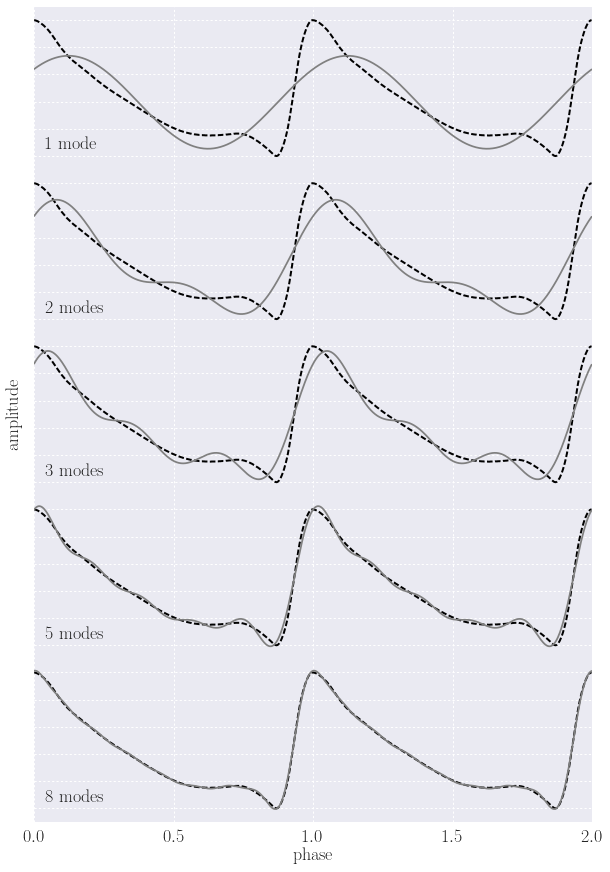

In [59]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_rrlyrae_templates

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)


#------------------------------------------------------------
# Load the RR Lyrae template
templates = fetch_rrlyrae_templates(data_home='/Users/ivezic/astroML_data')
x, y = templates['115r'].T

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 15))
fig.subplots_adjust(hspace=0)

kvals = [1, 2, 3, 5, 8]
subplots = [511, 512, 513, 514, 515]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    # reconstruct using k frequencies
    y_fft = np.fft.fft(y) # compute FFT
    y_fft[k + 1:-k] = 0 # zero-out frequencies higher than k
    y_fit = np.fft.ifft(y_fft).real # reconstruct using k modes

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[2]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()

## Model Parameter Estimation

Time series analysis can be conducted in either the time domain or the frequency domain.  We'll first start with a discussion of the time domain by introducing tools that we will discuss in detail in two weeks, like parameter estimation and regression.

We can fit a model to $N$ data points $(t_i,y_i)$:

$$y_i(t_i) = \sum_{m=1}^M \beta_m T_m(t_i|\theta_m) + \epsilon_i,$$

where the functions, $T_m$, do not need to be periodic, $t_i$ does not need to be evenly sampled and $\theta_m$ are the model parameters.

So, for example, if we have

$$y_i(t_i) = a \sin(\omega_0 t_i) + b \cos (\omega_1 t_i),$$

then $a=\beta_0$, $b=\beta_1$, $\omega_0=\theta_0$, and $\omega_1 = \theta_1$.

Determining whether a variable model is favored over a non-variable model is the same as we have dealt with previously and can also be approached using the AIC, BIC, or Bayesian odds ratio.  Once the model parameters, $\theta_m$ have been determined, we can further apply supervised or unsupervised classification methods to gain further insight.

Common deterministic models include

$$T(t) = \sin(\omega t)$$

and

$$T(t) = \exp(-\alpha t),$$

where the frequency, $\omega$, and decay rate, $\alpha$, are parameters to be estimated from the data.

We will also explore a so-called "chirp" signal with

$$T(t) = \sin(\phi + \omega t + \alpha t^2).$$

(another way of thinking of a chirp is that the *frequency varies with time*; $\omega_{\rm instantaneous} = \omega + \alpha t$)

### For a periodic signal we have:

$$y(t+P)=y(t),$$ where $P$ is the period.

We can create a *phased light curve* that plots the data as function of phase:

$$\phi=\frac{t}{P} − {\rm int}\left(\frac{t}{P}\right),$$

where ${\rm int}(x)$ returns the integer part of $x$.


### A Single Sinusoid

Let's take the case where the data are drawn from a single sinusoidal signal:

$$y(t)=A \sin(\omega t+\phi)+\epsilon$$

and determine whether or not the data are indeed consistent with periodic variability and, if so, what is the period.

We can use trig identies to rewrite the model as

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

where $A=(a^2+b^2)^{1/2}$ and $\phi=\tan^{−1}(b/a)$.

The model is now linear with respect to coefficients $a$ and $b$ (and nonlinear only with respect to frequency, $\omega$).  We now seek to determine the values of those parameters.



The simplified posterior for $\omega$ comes out to be

$$ p(\omega|\{t,y\}, \sigma) \propto \exp \left(\frac{P(\omega)}{\sigma^2} \right),$$

where

$$P(\omega) = {1 \over N} [ I^2(\omega) + R^2(\omega)]$$

$$ I(\omega) = \sum_{j=1}^N y_j   \sin(\omega t_j), \; \; \; R(\omega) = \sum_{j=1}^N y_j  \cos(\omega t_j)$$

is the [periodogram](https://en.wikipedia.org/wiki/Periodogram), which is just a plot of the "power" at each possible period (as illustrated below):

<img src="figures/periodogram.png">


Below is an example of a periodogram generated using 100 points drawn from $y(t|P) = 10 + \sin(2\pi t/P),$ with $P=0.3$.  

[http://www.astroml.org/gatspy/periodic/lomb_scargle.html](http://www.astroml.org/gatspy/periodic/lomb_scargle.html) gives more information on astroML's implementation.
 

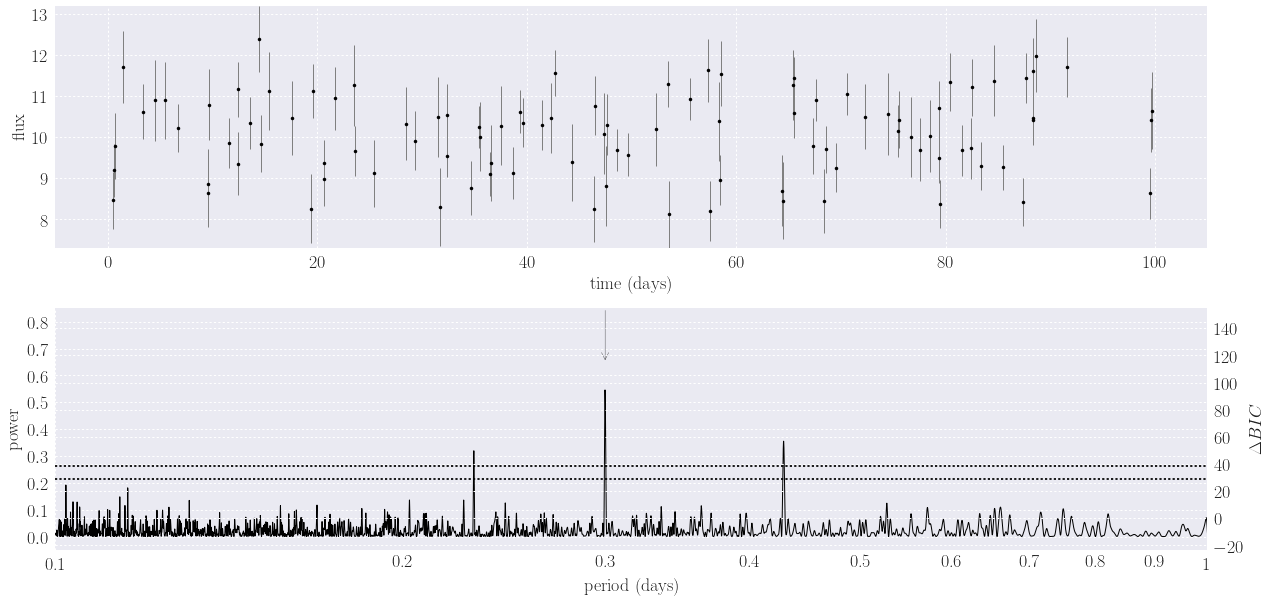

In [60]:
# Similar to Figure 10.15
# Author: Jake VanderPlas
# License: BSD
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 100
P = 0.3

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=500, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

 ## Finding a chirp or burst in a time series

Imagine a stationary signal $y(t)=b_0+\epsilon$ with an injected signal at time $T$ (possibly followed by a decay to the original level $b_0$ over some unknown time period).

This injected signal could be a "burst"

$$y(t)=b_0 + A\exp[−\alpha(t−T)]$$

or a ["chirp"](https://en.wikipedia.org/wiki/Chirp)

$$y(t)=b_0+A \sin[\omega t+\beta t^2].$$

Below is an example of using MCMC to fit a chirp signal.

Try changing the parameters such that the system is 1) very well modeled and 2) very poorly modeled.

 [-----------------100%-----------------] 20000 of 20000 complete in 4.4 sec

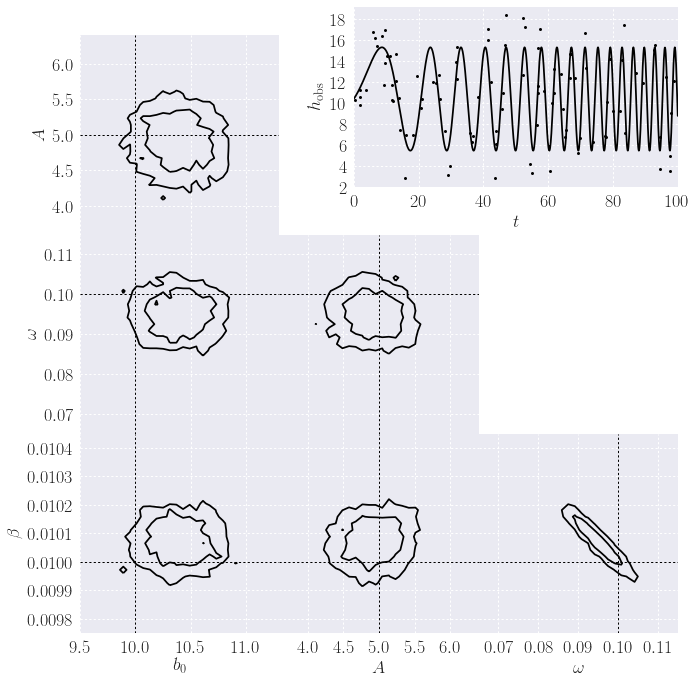

In [61]:
# Ivezic, Figure 10.26
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

#----------------------------------------------------------------------
# Set up toy dataset
def chirp(t, b0, beta, A, omega):
    return b0 + A * np.sin(omega * t + beta * t * t)

np.random.seed(0)

# Change these parameters to see what effect they have on how
# well the system can be modeled.
N = 100
b0_true = 10
A_true = 5
beta_true = 0.01
omega_true = 0.1
sigma = 2.0

# Number of iterations of the fitter
niter = 20000

t = 100 * np.random.random(N)

y_true = chirp(t, b0_true, beta_true, A_true, omega_true)
y_obs = np.random.normal(y_true, sigma)

t_fit = np.linspace(0, 100, 1000)
y_fit = chirp(t_fit, b0_true, beta_true, A_true, omega_true)

i = np.argsort(t)

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
log_beta = pymc.Uniform('log_beta', -10, 10, value=-4.6)
log_omega = pymc.Uniform('log_omega', -10, 10, value=-2.3)

# uniform prior on log(beta)
@pymc.deterministic
def beta(log_beta=log_beta):
    return np.exp(log_beta)

# uniform prior on log(omega)
@pymc.deterministic
def omega(log_omega=log_omega):
    return np.exp(log_omega)

@pymc.deterministic
def y_model(t=t, b0=b0, A=A, beta=beta, omega=omega):
    return chirp(t, b0, beta, A, omega)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A,
             log_beta=log_beta, beta=beta,
             log_omega=log_omega, omega=omega,
             y_model=y_model, y=y)

#----------------------------------------------------------------------
# Run the MCMC sampling (saving results to a pickle)
def compute_MCMC_results(niter=niter, burn=2000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'omega', 'beta']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.beta.value, M.A.value, M.omega.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', r'$\omega$', r'$\beta$']
limits = [(9.5, 11.3), (3.6, 6.4), (0.065, 0.115), (0.00975, 0.01045)]
true = [b0_true, A_true, omega_true, beta_true]

#----------------------------------------------------------------------
# Find the Maximum a posteriori values
fig = plt.figure(figsize=(10, 10))

ax = plt.axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1001)
y_fit = chirp(t_fit, *fit_vals)
plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.plot(t_fit, y_fit, '-k')
plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, bounds=[0.12, 0.08, 0.95, 0.91], colors='k')
plt.show()

 ## That's it folks! Thanks for you attention and I hope that you found at least something interesting and useful in these lectures! 